In [31]:
from math import *
import numpy as np
from scipy.linalg import expm
from qutip import *
import random
from scipy import optimize
from datetime import datetime
import time
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from qutip import bloch, Qobj

In [32]:
# complex number
j = (-1)**0.5


# pauli matrix
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -j], [j, 0]])
sz = np.array([[1, 0], [0, -1]])
s0 = np.array([[1, 0], [0, 1]])

# define step size
dt = 1 # 고정
N = 1600 # 임의의 시구간
T = np.linspace(0,N,N+1) # N+1구간으로 쪼갬

phi_t = (np.cos(2*np.pi*T/N))**2 # phi_t에 대한 특정 조건이 없으므로, 그냥 임의로 잡았음
d0 = 0.15

In [33]:
def Rx(t):
    w = 0.02 #gate도 결국 pulse의 시간에 의해서 결정. 단위시간 당 0.02radian변화하도록 설정
    theta = w*t
    return np.matrix([[cos(theta/2),     -1j*sin(theta/2)],
                    [-1j*sin(theta/2),     cos(theta/2)]])


def Ry(t):
    w = 0.02
    theta = w*t
    return np.matrix([[cos(theta/2),     -sin(theta/2)],
                    [sin(theta/2),     cos(theta/2)]])

def Rxm(t):
    w = 0.02 
    theta = -w*t
    return np.matrix([[cos(theta/2),     -1j*sin(theta/2)],
                    [-1j*sin(theta/2),     cos(theta/2)]])


def Rym(t):
    w = 0.02
    theta = -w*t
    return np.matrix([[cos(theta/2),     -sin(theta/2)],
                    [sin(theta/2),     cos(theta/2)]])


def Rz(t): # Rz는 사용하지 않음. 해밀토니안에 의한 회전으로만 컨트롤
    w = 0.02
    phi = w*t
    return np.matrix([[cos(phi/2)-1j*sin(phi/2),       0],
                     [0,                          cos(phi/2)+1j*sin(phi/2)]])

In [34]:
def dH(t):
    
    #H = d0*phi_t[t]*sz
    H = s0
    return H

def dU(dH) :
    return expm(-j*dH)

# fielity 계산을 위한 함수(일단은 안 쓸 예정)

def state_fidelity(rho_1, rho_2): #fidelity
        if np.shape(rho_1) != np.shape(rho_2):
            print("Dimensions of two states do not match.")
            return 0
        else:
            sqrt_rho_1 = fractional_matrix_power(rho_1, 1 / 2)
            fidelity = (np.trace(fractional_matrix_power(sqrt_rho_1 @ rho_2 @ sqrt_rho_1, 1 / 2))) ** 2
            return np.real(fidelity)

In [35]:
def problem_by_fidelity(irho,irho_target,k):
    byRz = dU(dH(k))@irho@dU(dH(k)).conj().T
    byRx = Rx(8) @ byRz @ Rx(8).conj().T
    byRy = Ry(8) @ byRz @ Ry(8).conj().T
    byRxm = Rxm(8) @ byRz @ Rxm(8).conj().T
    byRym = Rym(8) @ byRz @ Rym(8).conj().T
    choice_list = [byRz,byRx,byRy,byRxm,byRym]
    F_next = 0
    i=0
    for j in choice_list:
        byRz_next = dU(dH(k+1))@j@dU(dH(k+1)).conj().T
        byRx_next = Rx(8) @ byRz_next @ Rx(8).conj().T
        byRy_next = Ry(8) @ byRz_next @ Ry(8).conj().T
        byRxm_next = Rxm(8) @ byRz_next @ Rxm(8).conj().T
        byRym_next = Rym(8) @ byRz_next @ Rym(8).conj().T
        F_next_list = [state_fidelity(irho_target,byRz_next),state_fidelity(irho_target,byRx_next),state_fidelity(irho_target,byRy_next),state_fidelity(irho_target,byRxm_next),state_fidelity(irho_target,byRym_next)]
        if F_next < max(F_next_list):
            F_next =max(F_next_list)
            choice = i
        i+=1
        
    F_for_only_rz = state_fidelity(irho_target,byRz)
    F_by_rx = state_fidelity(irho_target,byRx)
    F_by_ry = state_fidelity(irho_target,byRy)
    F_by_rxm = state_fidelity(irho_target,byRxm)
    F_by_rym = state_fidelity(irho_target,byRym)
    F = [F_for_only_rz,F_by_rx,F_by_ry,F_by_rxm,F_by_rym]     # 각 선택에 대한 cost를 리스트에 임시 저장

    return F[choice], choice_list[choice], choice  # cost, 변환된 density matrix, 선택한 opreation index 저장 

In [36]:
# define initial state

init_wave = np.array([[1],[0]])
irho_init = np.kron(init_wave,init_wave.conj().T)

In [37]:
gate_choice = np.zeros(1601)
xyz_trace = np.zeros((3,1601))
xyz_trace[2][0] = 1
cost_ls = np.zeros(1601)


In [38]:
def find_TOC_gate ():
    target_theta, target_phi = pi/2,3*pi/4
    irho_target= Rz(target_phi/0.02) @ Rx(target_theta/0.02) @ irho_init @ Rx(target_theta/0.02).conj().T @ Rz(target_phi/0.02).conj().T
    xyz_target = [np.trace(irho_target*sx).real,np.trace(irho_target*sy).real,np.trace(irho_target*sz).real]
    k=1
    irho_mid = irho_init
    cost=0
    for i in range(1, N-1):
        cost, irho_mid, choice = problem_by_fidelity(irho_mid,irho_target,i)
        #cost, irho_mid, choice = problem(irho_mid,irho_target,i)
        gate_choice[i] = choice
        xyz_trace[0][i] = np.trace(irho_mid*sx).real
        xyz_trace[1][i] = np.trace(irho_mid*sy).real
        xyz_trace[2][i] = np.trace(irho_mid*sz).real
        cost_ls[i] = cost
        k+=1
        if cost > 0.99:
            return k
    return 0

In [39]:
tot_time = find_TOC_gate()

[0. 2. 3. 3. 2. 2. 3. 3. 2. 2. 3. 3. 2. 2.]


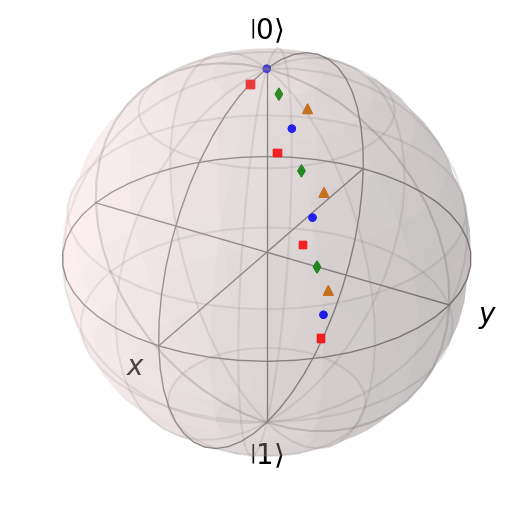

In [40]:
b = Bloch()
for i in range(0,tot_time):
    point = ([xyz_trace[0][i],
        xyz_trace[1][i],
        xyz_trace[2][i]])
    b.add_points(point)

#points = Qobj((points))

print(gate_choice[0:tot_time])
#b.add_states(points, kind='line')
b.show()